<div style="text-align:center;">
    <img src="http://www.infante.space/wp-content/uploads/2018/02/Logo-FEUP.png" width="35%"/>
    <h1 style="font-size: 2.5em">Credit Risk Analysis</h1>
    <h2 style="font-size: 2em">Artificial Intelligence 2020/21 - Supervised Learning</h2>
</div>

## Table of contents

1. [Introduction](#Introduction)

2. [License](#License)

3. [Required libraries](#Required-libraries)

4. [The problem domain](#The-problem-domain)

5. [Step 1: Answering the question](#Step-1:-Answering-the-question)

6. [Step 2: Checking the data](#Step-2:-Checking-the-data)

7. [Step 3: Tidying the data](#Step-3:-Tidying-the-data)

    - [Bonus: Testing our data](#Bonus:-Testing-our-data)

8. [Step 4: Exploratory analysis](#Step-4:-Exploratory-analysis)

9. [Step 5: Classification](#Step-5:-Classification)

    - [Cross-validation](#Cross-validation)

    - [Parameter tuning](#Parameter-tuning)

10. [Step 6: Reproducibility](#Step-6:-Reproducibility)

11. [Conclusions](#Conclusions)

12. [Further reading](#Further-reading)

13. [Acknowledgements](#Acknowledgements)

## Introduction

In this project we look forward to use Machine Learning, more specifically, Supervised Learning, to predict the risk on loan repayment. For this, we use a provided dataset with approximatelly 800k entries of previously issued loans and aim to train this dataset using various machine learning algorithms.

## License

Please see the repository README file for the licenses and usage terms for the instructional material and code in this notebook.

## Required libraries

- **numpy** - provides support for large multidimensional arrays and matrices along with a collection of high-level mathematical functions to execute these functions swiftly.
- **pandas** - enables the provision of easy data structure and quicker data analysis for Python. For operations like data analysis and modelling, Pandas makes it possible to carry these out without needing to switch to more domain-specific language.
- **scikit-learn** - can be effectively used for a variety of applications which include classification, regression, clustering, model selection, naive Bayes’, grade boosting, K-means, and preprocessing.
- **matplotlib** - widely used for publication of quality figures in a variety of hard copy formats and interactive environments across platforms. Used to design charts, graphs, pie charts, scatterplots, histograms, error charts, etc.
- **seaborn** - visualisation of statistical models like heat maps.
- **watermark** - printing date and time stamps, version numbers, and hardware information.
- **contextlib**
- **time**

## Initialization

### Importing modules

In [2]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifie
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import time
import sys
from sklearn import preprocessing

### Cleaning and Normalization

After a thorough analysis of the data available, it was decided to drop a considerable amount of columns from the dataset. It includes columns containing either data that was not relevant to the problem or columns with too many missing values to be used reliably.
For example: identifiers, titles and descriptions; zip codes.
We also created new columns using old ones with, for example, date differences and differences of money amounts, replaced 'grade' column with the 'sub_grade' column

#### Removing unnecessary columns

In [2]:
df = pd.read_csv('./resources/data.csv', index_col=0)

# Remove id column and use a default index
df.reset_index(drop=True, inplace=True)

df.drop(columns = [
        'member_id',
        'grade',
        'emp_title',
        'pymnt_plan',
        'desc',
        'title',
        'zip_code',
        'initial_list_status',
        'out_prncp_inv',
        'total_pymnt_inv',
        'funded_amnt_inv',
        'total_rec_prncp',
        'total_rec_int',
        'total_rec_late_fee',
        'collection_recovery_fee',
        'last_pymnt_d',
        'last_pymnt_amnt',
        'next_pymnt_d',
        'last_credit_pull_d',
        'collections_12_mths_ex_med',
        'mths_since_last_major_derog',
        'policy_code',
        'application_type',
        'annual_inc_joint',
        'dti_joint',
        'verification_status_joint',
        'open_acc_6m',
        'open_il_6m',
        'open_il_12m',
        'open_il_24m',
        'mths_since_rcnt_il',
        'total_bal_il',
        'il_util',
        'open_rv_12m',
        'open_rv_24m',
        'max_bal_bc',
        'all_util',
        'inq_fi',
        'total_cu_tl',
        'inq_last_12m',
        'total_rev_hi_lim',
        'open_acc',
        'mths_since_last_record',
        'mths_since_last_delinq'
        ], inplace = True)

df.to_csv("afterRemoving.csv")

/root/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (17,45,53) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### Renaming, replacing and aggregating

In [3]:

df = pd.read_csv('./afterRemoving.csv', index_col=0)

# Remove "months" in column "term"
df.term = df.term.str.split().str[0]

# Rename column "sub_grade" to "grade"
df.rename(columns={'sub_grade':'grade'}, inplace = True)

# Normalize emp_length
def normalize_emp_length(emp_length):
    if (emp_length == None or (not type(emp_length) is str)):
        return
    if (emp_length == '< 1 year'):
        return '0'
    elif (emp_length == '10+ years'):
        return '10'
    else:
        return emp_length.split()[0]

df.emp_length = df.emp_length.apply(normalize_emp_length)

df.emp_length = pd.to_numeric(df.emp_length, downcast='integer') # TODO: fix the conversion (current -> float64, desired -> int8)

df.to_csv('afterRename.csv')

### Convert types
To save memory usage and processing time, the data types of the columns in the dataset were changed, accordingly to the range of the corresponding data.

In [4]:
import sys
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifie
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

df = pd.read_csv('./afterRename.csv', index_col=0)

def convertTypes(df):
    df.loan_amnt = df.loan_amnt.astype('uint32')
    df.term = df.term.astype('uint8')
    df.int_rate = df.int_rate.astype('float16')
    df.installment = df.installment.astype('float16')
    df.grade = df.grade.astype('category')
    df.home_ownership = df.home_ownership.astype('category')
    df.annual_inc = df.annual_inc.astype('uint32')
    df.verification_status = df.verification_status.astype('category')
    df.purpose = df.purpose.astype('category')
    df.addr_state = df.addr_state.astype('category')
    df.dti = df.dti.astype('float16')
    df.delinq_2yrs = df.delinq_2yrs.astype('uint8')
    df.inq_last_6mths = df.inq_last_6mths.astype('uint8')
    df.pub_rec = df.pub_rec.astype('uint8')
    df.revol_bal = df.revol_bal.astype('uint32')
    df.total_acc = df.total_acc.astype('uint8')
    df.out_prncp = df.out_prncp.astype('float16')
    df.total_pymnt = df.total_pymnt.astype('float16')
    df.recoveries = df.recoveries.astype('float16')
    df.acc_now_delinq = df.acc_now_delinq.astype('category')
    df.default_ind = df.default_ind.astype('bool')   

    return df
    
def convertTypesImputer(df):
    df.loan_amnt = df.loan_amnt.astype('uint32')
    df.term = df.term.astype('uint8')
    df.int_rate = df.int_rate.astype('float16')
    df.installment = df.installment.astype('float16')
    df.annual_inc = df.annual_inc.astype('uint32')
    df.dti = df.dti.astype('float16')
    df.delinq_2yrs = df.delinq_2yrs.astype('uint8')
    df.inq_last_6mths = df.inq_last_6mths.astype('uint8')
    df.pub_rec = df.pub_rec.astype('uint8')
    df.revol_bal = df.revol_bal.astype('uint32')
    df.total_acc = df.total_acc.astype('uint8')
    df.out_prncp = df.out_prncp.astype('float16')
    df.total_pymnt = df.total_pymnt.astype('float16')
    df.recoveries = df.recoveries.astype('float16')
    df.default_ind = df.default_ind.astype('bool')
    return df
    
def read_and_convert_imp(file):
    df = pd.read_csv(file, index_col=0)
    df = convertTypesImputer(df)
    return df


def read_and_convert(file):
    df = pd.read_csv(file, index_col=0)
    df = convertTypes(df)
    return df

df = convertTypes(df)
df.earliest_cr_line = df.earliest_cr_line.astype('datetime64')
df.issue_d = df.issue_d.astype('datetime64')

df['since_first_cr'] = ((df['issue_d'] - df['earliest_cr_line']) / np.timedelta64(1, 'M')).astype('uint16')
df['diff_loan_funded_amnt'] = (df['loan_amnt'] - df['funded_amnt']).astype('uint16')
    
df.drop(columns = [
        'issue_d',
        'earliest_cr_line',
        'funded_amnt'
        ], inplace = True)


df.to_csv("afterConverting.csv")
#convertTypes(df)
#df.info()

# stratified_sample, _ = train_test_split(df, test_size=0.9, stratify=df[['default_ind']])



## Undersampling
### (Same amount of rows with default_ind = 0 and default_ind = 1)

In [71]:
df = read_and_convert('./afterConverting.csv')

# Shuffle the Dataset.
# df = df.sample(frac=1,random_state=4)
df, _ = train_test_split(df, test_size=0.9, stratify=df[['default_ind']]) #SAMPLE STRAT

df.to_csv("afterSampling.csv")

"""
# Put all the fraud class in a separate dataset.
fraud_df = shuffled_df.loc[shuffled_df['default_ind'] == 1]

# Randomly select 46467 observations from the non-fraud (majority class)
non_fraud_df = shuffled_df.loc[shuffled_df['default_ind'] == 0].sample(n=fraud_df['default_ind'].count(),random_state=42)

# Concatenate both dataframes again
df = pd.concat([fraud_df, non_fraud_df])

# plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sb.countplot('default_ind', data=df)
plt.title('Balanced Classes')
plt.show()
"""

"\n# Put all the fraud class in a separate dataset.\nfraud_df = shuffled_df.loc[shuffled_df['default_ind'] == 1]\n\n# Randomly select 46467 observations from the non-fraud (majority class)\nnon_fraud_df = shuffled_df.loc[shuffled_df['default_ind'] == 0].sample(n=fraud_df['default_ind'].count(),random_state=42)\n\n# Concatenate both dataframes again\ndf = pd.concat([fraud_df, non_fraud_df])\n\n# plot the dataset after the undersampling\nplt.figure(figsize=(8, 8))\nsb.countplot('default_ind', data=df)\nplt.title('Balanced Classes')\nplt.show()\n"

## Handling Missing Values

In [72]:
df = read_and_convert('./afterSampling.csv')

print("Columns left with missing values before imputation: ")
print(df.isnull().sum())


start = time.time()

newDf = df[df.columns.difference(['grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state'])]
imputer = KNNImputer(n_neighbors=2)
#newDf = imputer.fit_transform(df[['emp_length', 'revol_util', 'tot_coll_amt', 'tot_cur_bal', 'loan_amnt','annual_inc', 'dti', 'delinq_2yrs', 'pub_rec']])
newDf = pd.DataFrame(imputer.fit_transform(newDf), columns = newDf.columns)
print("KNNImputer completed in {} seconds".format(time.time()-start))
newDf.to_csv("Imputed.csv")



#newDf = read_and_convert_imp("Imputed.csv")

# Replace emp_length | revol_util | tot_coll_amt | loan_amnt columns with calculated values
df['emp_length'] = newDf['emp_length'].values
df['revol_util'] = newDf['revol_util'].values
df['tot_coll_amt'] = newDf['tot_coll_amt'].values
df['tot_cur_bal'] = newDf['tot_cur_bal'].values


#np.set_printoptions(threshold=sys.maxsize)
#print(newDf[:,0] )
"""
df.emp_length = df.emp_length.astype('float16')
df.revol_util = df.revol_util.astype('float16')
df.tot_coll_amt = df.tot_coll_amt.astype('float64')
df.tot_cur_bal = df.tot_cur_bal.astype('float64')
"""

df.to_csv("AfterKNNImputer.csv")

df.to_csv("data_clean.csv")

# Columns with missing values
print("\nColumns left with missing values after imputation: ")
print(df.columns[df.isnull().any()].tolist())
print(df.isnull().sum())

Columns left with missing values before imputation: 
loan_amnt                    0
term                         0
int_rate                     0
installment                  0
grade                        0
emp_length                8609
home_ownership               0
annual_inc                   0
verification_status          0
purpose                      0
addr_state                   0
dti                          0
delinq_2yrs                  0
inq_last_6mths               0
pub_rec                      0
revol_bal                    0
revol_util                  82
total_acc                    0
out_prncp                    0
total_pymnt                  0
recoveries                   0
acc_now_delinq               0
tot_coll_amt             13376
tot_cur_bal              13376
default_ind                  0
since_first_cr               0
diff_loan_funded_amnt        0
dtype: int64


KeyboardInterrupt: 

## Removal of Outliers (Z-Score)

In [11]:
from scipy import stats

def remove_outliers(_df):
    z = np.abs(stats.zscore(_df.select_dtypes(exclude=['object', 'bool'])))

    #_df.to_csv('original.csv')
    #testDf = df.select_dtypes(exclude=['object', 'bool'])
    testDf = _df
    testDf = testDf[(z < 4).all(axis=1)]
    #testDf.info()

    #testDf.to_csv('test1.csv')
    return testDf

## Correlation

### Before 

In [8]:
df = read_and_convert('./afterConverting.csv')
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,recoveries,tot_coll_amt,tot_cur_bal,default_ind,since_first_cr,diff_loan_funded_amnt
loan_amnt,1.000000,0.411192,0.142956,0.944865,0.105435,0.335209,0.020187,-0.000739,-0.028928,-0.082199,0.337489,0.119635,0.222084,0.639784,0.479613,0.075513,-0.004272,0.329130,-0.004907,0.185764,0.037330
term,0.411192,1.000000,0.427405,0.143852,0.068726,0.059057,0.050146,-0.000451,-0.001365,-0.025197,0.093388,0.085896,0.101665,0.391228,0.083998,0.059381,-0.002323,0.110597,0.031378,0.056423,0.033078
int_rate,0.142956,0.427405,1.000000,0.130456,0.010739,-0.073826,0.078442,0.055404,0.231714,0.052597,-0.035346,0.271704,-0.039483,0.033896,0.173421,0.110863,0.001130,-0.091436,0.155056,-0.114435,-0.001306
installment,0.944865,0.143852,0.130456,1.000000,0.089893,0.328578,0.013908,0.007224,0.001660,-0.071114,0.320017,0.131928,0.199871,0.539835,0.520615,0.076930,-0.003540,0.298350,0.004753,0.162400,-0.009765
emp_length,0.105435,0.068726,0.010739,0.089893,1.000000,0.063678,0.043621,0.025525,-0.006192,0.032278,0.087927,0.034710,0.102332,0.073712,0.050234,0.004329,-0.000564,0.097365,-0.014133,0.226807,-0.004707
annual_inc,0.335209,0.059057,-0.073826,0.328578,0.063678,1.000000,-0.086814,0.047749,0.037251,-0.008909,0.298569,0.036753,0.188651,0.211550,0.163226,0.007613,0.001005,0.422618,-0.037066,0.151238,0.011492
dti,0.020187,0.050146,0.078442,0.013908,0.043621,-0.086814,1.000000,-0.002676,-0.005860,-0.022715,0.067113,0.086642,0.106258,0.058052,-0.040534,0.001719,-0.001995,-0.007132,0.004428,0.026159,-0.009903
delinq_2yrs,-0.000739,-0.000451,0.055404,0.007224,0.025525,0.047749,-0.002676,1.000000,0.022930,-0.011081,-0.031807,-0.016299,0.121978,0.030884,-0.031777,-0.000252,0.000154,0.064618,-0.009186,0.092053,-0.008214
inq_last_6mths,-0.028928,-0.001365,0.231714,0.001660,-0.006192,0.037251,-0.005860,0.022930,1.000000,0.059430,-0.018683,-0.088353,0.141854,-0.104062,0.080476,0.044003,0.003181,0.034806,0.074407,-0.005487,0.008628
pub_rec,-0.082199,-0.025197,0.052597,-0.071114,0.032278,-0.008909,-0.022715,-0.011081,0.059430,1.000000,-0.101235,-0.079050,0.012300,-0.007978,-0.087934,-0.014601,0.006816,-0.075956,-0.019607,0.077333,-0.010366


### After

In [9]:
df = read_and_convert('./AfterKNNImputer.csv')
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

FileNotFoundError: [Errno 2] No such file or directory: './afterKNNImputer.csv'

# ROC Curve

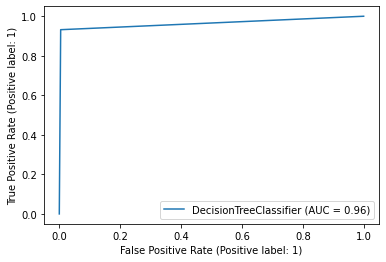

In [8]:
def roc_curve(classifier, testing_inputs, testing_classes):
    metrics.plot_roc_curve(classifier, testing_inputs, testing_classes)
    plt.show()

roc_curve(dtc,testing_inputs,testing_classes)

# Plots
## Relation between the loan amount, the annual income and the home ownership 

The circular points represent the accepted loans, and the cross points represent the declined ones.

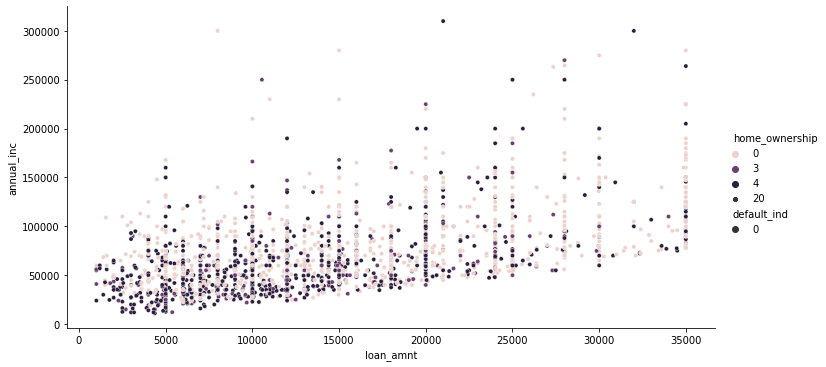

In [12]:
df_without_outliers = df
df_without_outliers = remove_outliers(df_without_outliers)

scatter = sb.relplot(x="loan_amnt", y="annual_inc", hue="home_ownership", style="default_ind", data=df_without_outliers.sample(n=2000,random_state=42), size=20, aspect=2)
scatter.savefig("plot1.png")

### Pair plot
#### Before the removal of outliers

/root/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/root/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


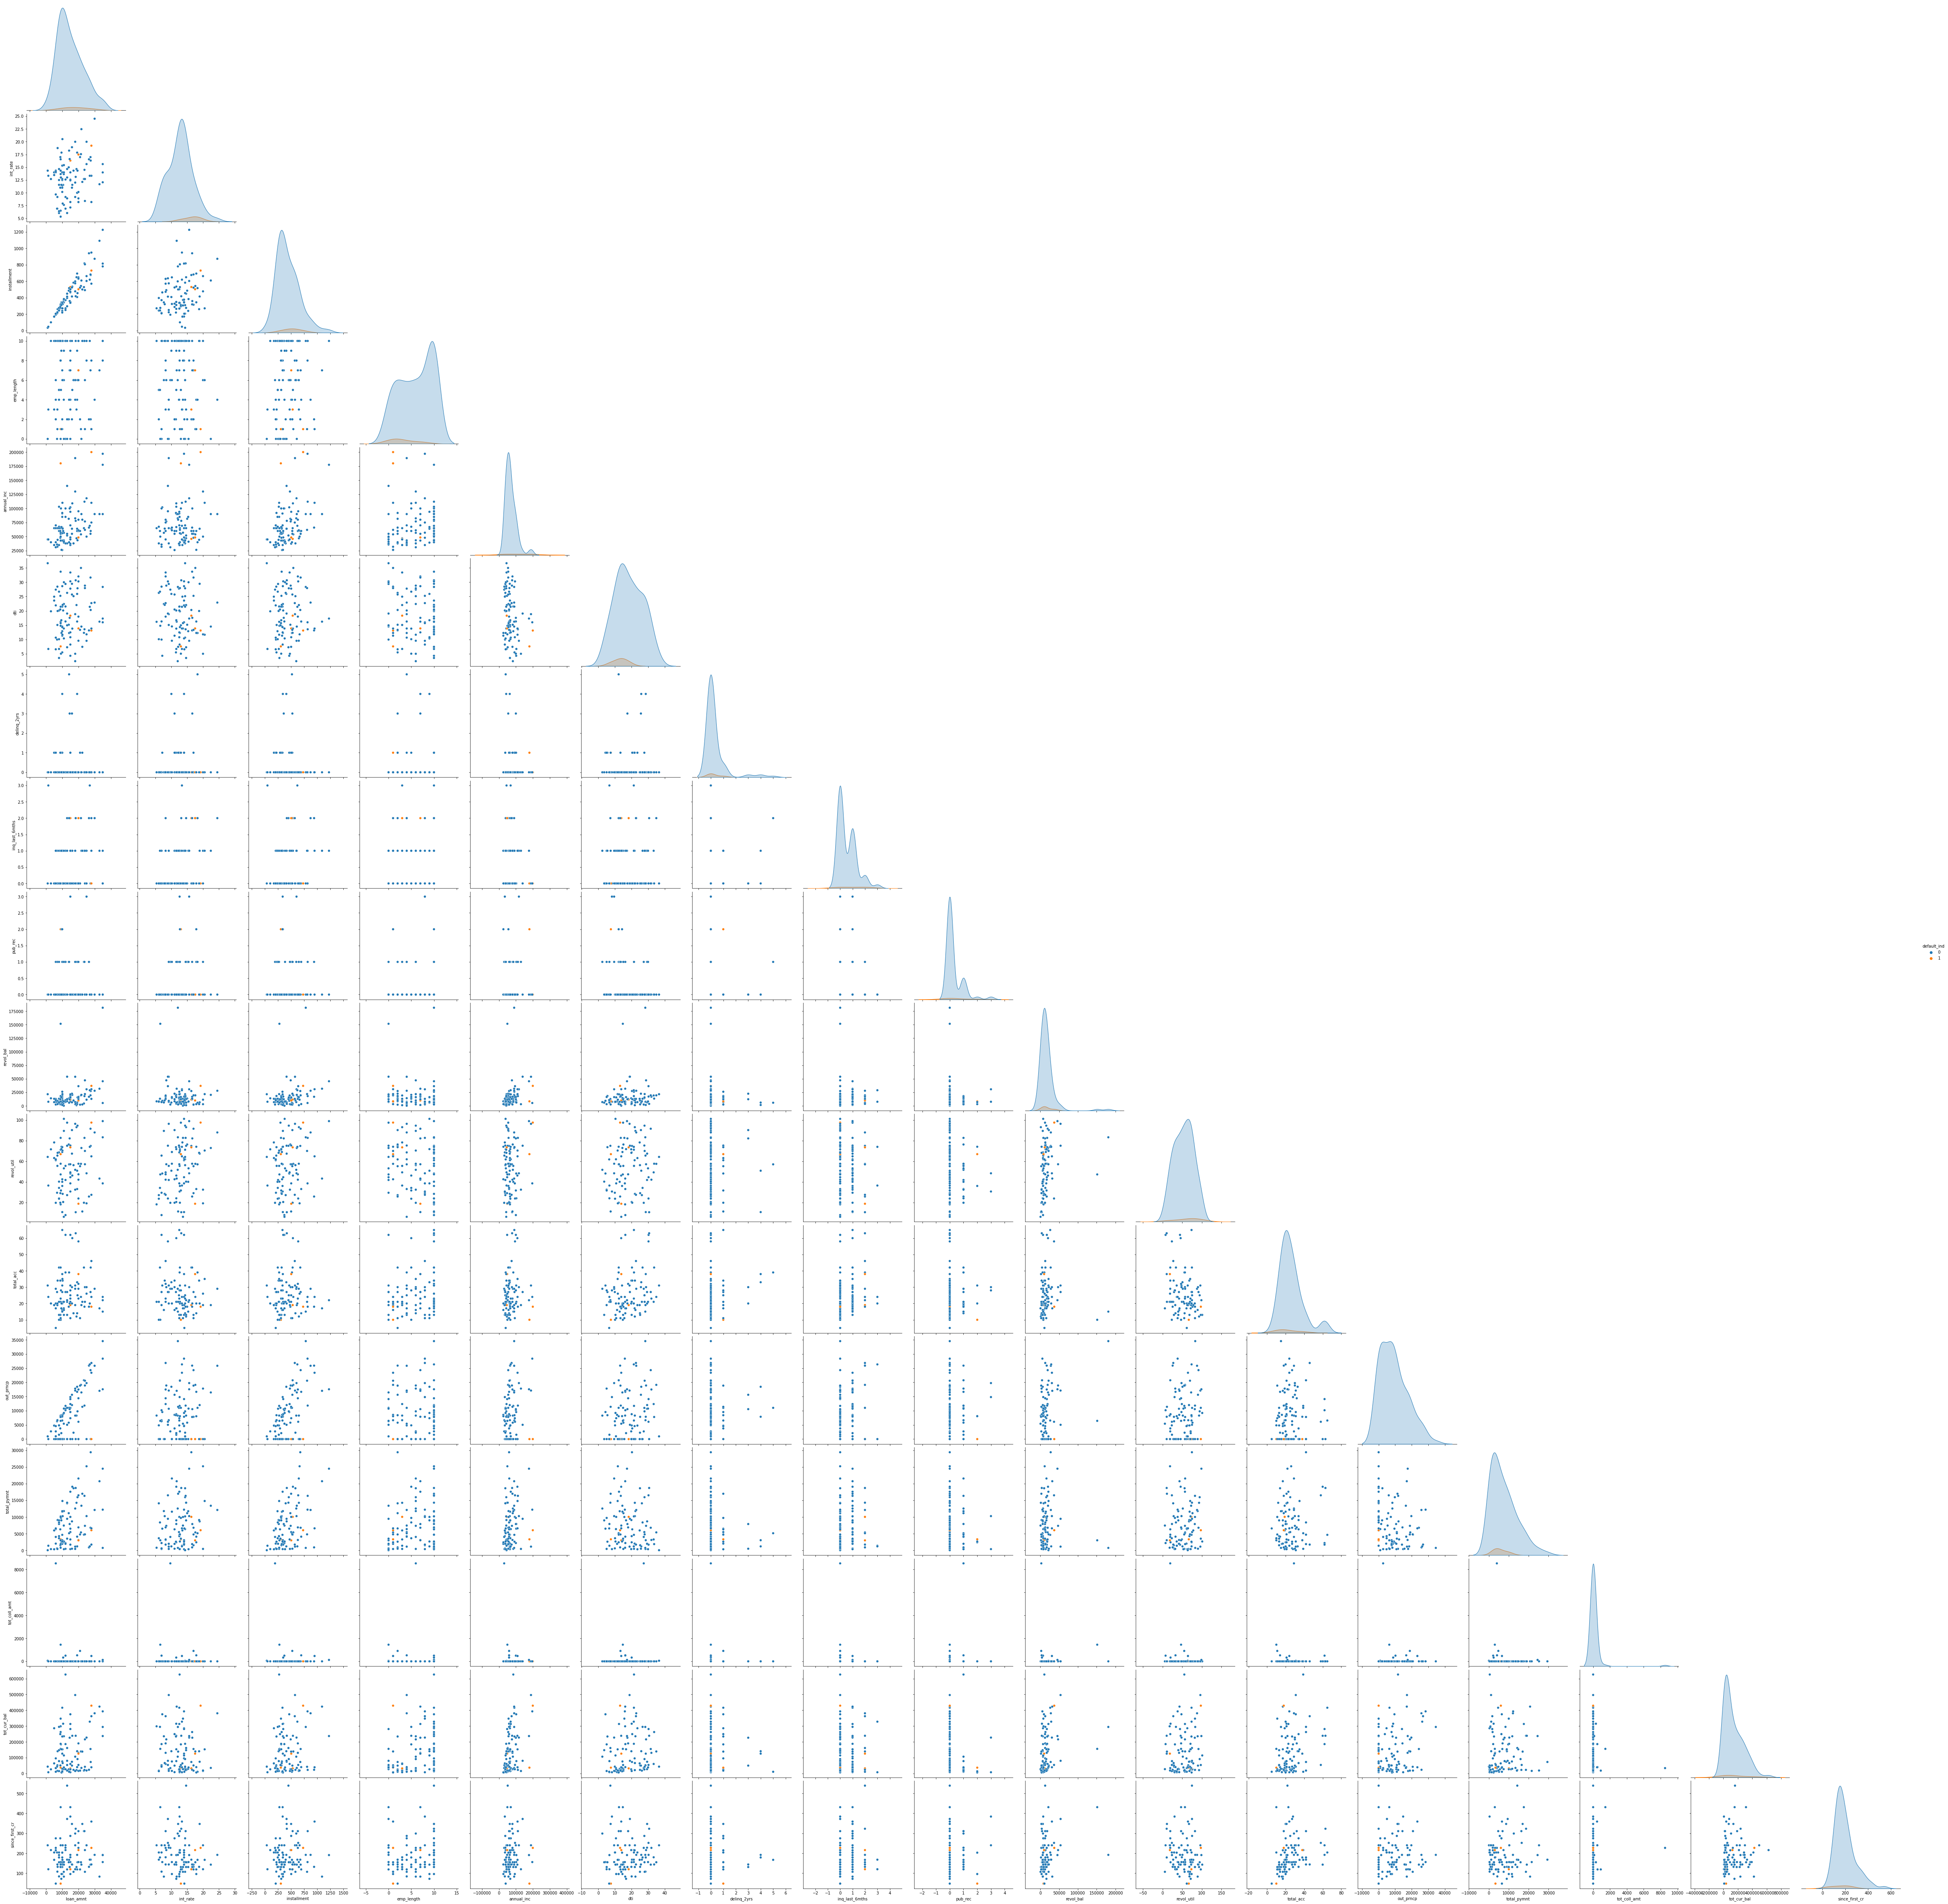

In [14]:
def pair_plot(df,output_name):
    columns_to_use = ["loan_amnt","int_rate","installment","emp_length","annual_inc","dti","delinq_2yrs","inq_last_6mths","pub_rec","revol_bal","revol_util","total_acc","out_prncp","total_pymnt","tot_coll_amt","tot_cur_bal","since_first_cr"]

    columns_not_to_use = ["grade","home_ownership","verification_status","purpose","addr_state","acc_now_delinq","term","default_ind","diff_loan_funded_amnt","recoveries"] # just to know what columns are not being used in the graph

    pair_plot = sb.pairplot(df.sample(n=2000,random_state=42), hue='default_ind', vars=columns_to_use, corner=True, height=4)

    # don't render the plot in the browser, to improve performance
    pair_plot.savefig(output_name)
    #plt.clf()

pair_plot(df, "pair_plot_before.png")

#### After the removal of outliers

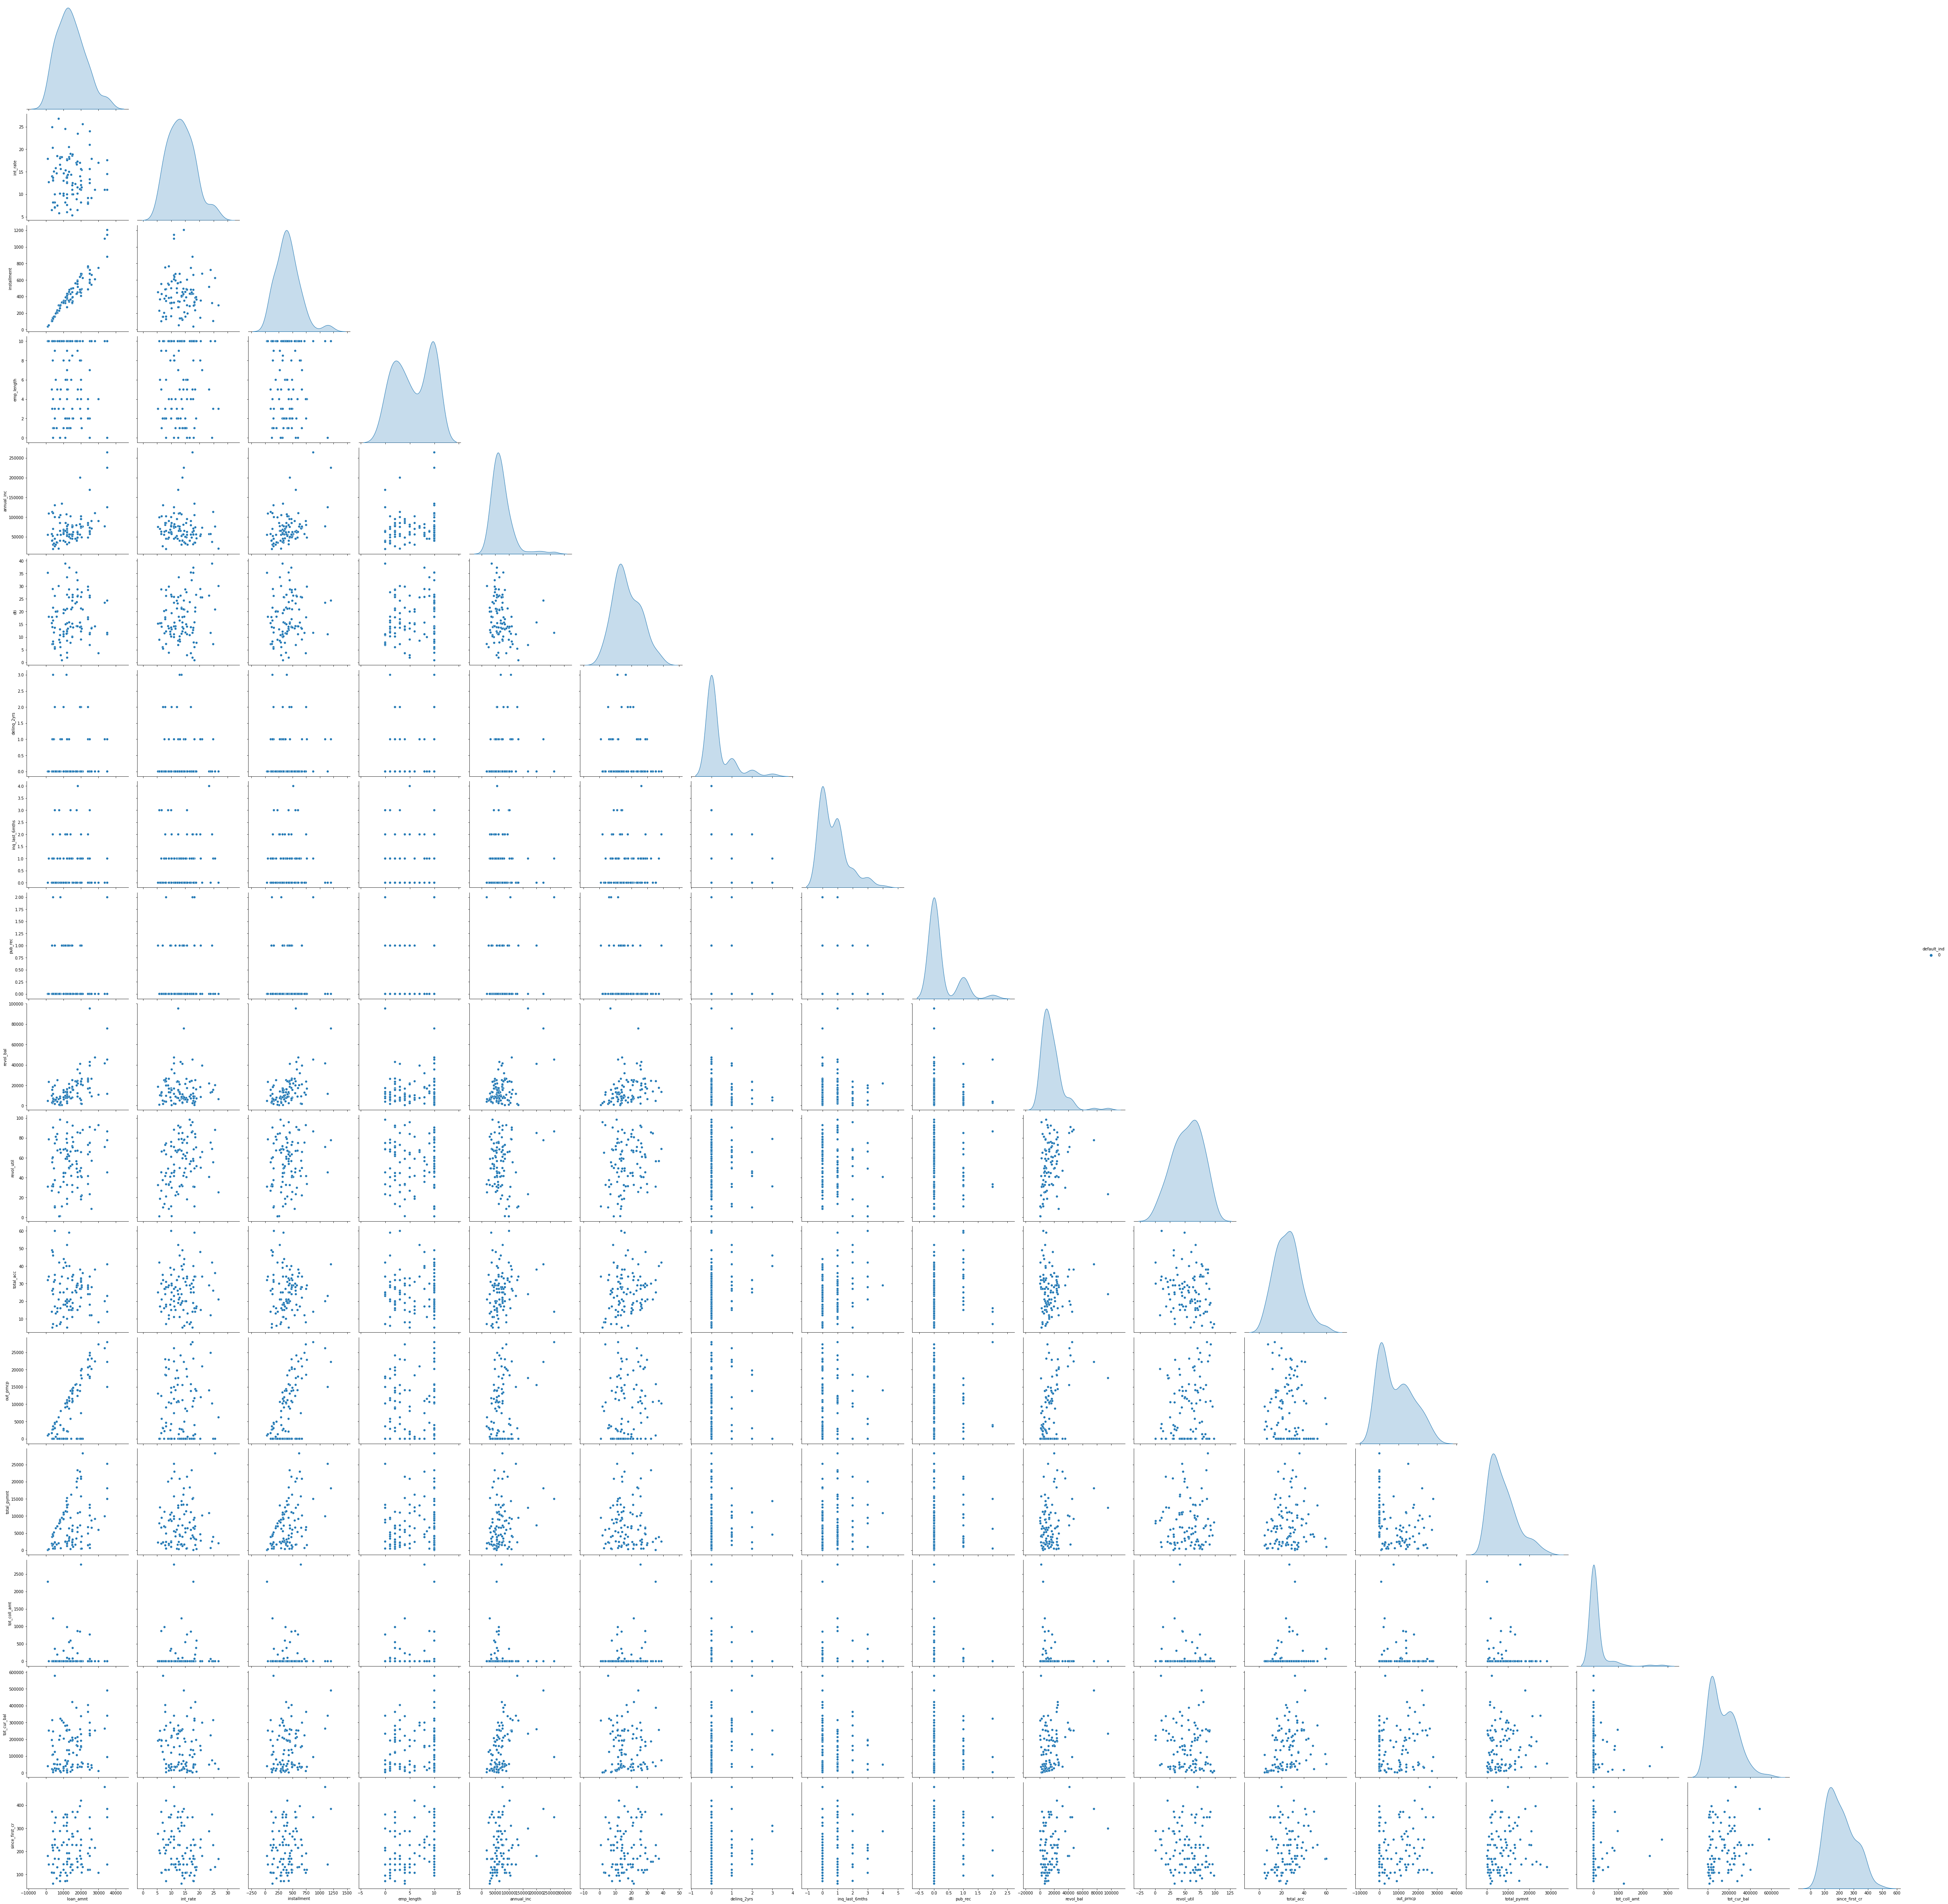

In [15]:
pair_plot(df_without_outliers, "pair_plot_after.png")

## Classification

### Decision Tree

In [3]:
df = pd.read_csv("data_clean.csv", index_col=0)
dtc = DecisionTreeClassifier()

dtc_df = df

from sklearn.preprocessing import LabelEncoder
columnsToEncode = list(dtc_df.select_dtypes(include=['category','object', 'bool']))
le = LabelEncoder()
for feature in columnsToEncode:
    try:
        dtc_df[feature] = le.fit_transform(dtc_df[feature])
    except:
        print('Error encoding '+feature)

X = dtc_df[df.columns.difference(['default_ind'])].values # Features
y = dtc_df['default_ind'].values

dtc_df.to_csv("testtt.csv")

(training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(X, y, test_size=0.25)
                
dtc.fit(training_inputs, training_classes)
print(len(training_inputs))
print(len(testing_inputs))
prediction_classes = dtc.predict(testing_inputs)

# with open('credit.dot', 'w') as out_file:
#    out_file = tree.export_graphviz(dtc, out_file=out_file)
    
# tree.plot_tree(dtc)

print("Confusion matrix:\n", metrics.confusion_matrix(testing_classes, prediction_classes))
print("Accuracy:",metrics.accuracy_score(testing_classes, prediction_classes))
print("Precision:", metrics.precision_score(testing_classes, prediction_classes, average='weighted'))

64197
21399
Confusion matrix:
 [[20146    92]
 [   79  1082]]
Accuracy: 0.992008972381887
Precision: 0.9920542062999886


In [32]:
model_accuracies = []

for repetition in range(10):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(X, y, test_size=0.90)
                
    dtc.fit(training_inputs, training_classes)
    classifier_accuracy = dtc.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
plt.hist(model_accuracies)

KeyboardInterrupt: 

In [ ]:
#sb.set_style("ticks", {"xtick.major.size":30000,"ytick.major.size":8000})

#sb.set_context("paper")

#plt.figure(figsize=(50, 10))

#fig = plt.gcf()

# Change seaborn plot size
#fig.set_size_inches(20, 10)

#sns_plot = sb.relplot(x="loan_amnt", y="annual_inc", hue="home_ownership", style="default_ind", data=df)

#sns_plot.savefig("output.png")

#sb.set_style('whitegrid')

#sb.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5,"xtick.major.size":3000,"ytick.major.size":800})

#fig, scatter = plt.subplots(figsize = (11,7))
scatter = sb.relplot(x="loan_amnt", y="annual_inc", hue="home_ownership", style="default_ind", data=df)
#scatter.set_xlabel('Loan Amount', size = 18)
#scatter.set_ylabel ('Annual Income', size = 18)
#scatter.legend(loc='upper right', size = 15);

scatter.savefig("output.png")

> RUI 

- Added 'bool' columns to LabelEncoder - Decision Tree
- AfterKNNImputer - Capital 'A'

# Cross-Validation

Text(0.5, 1.0, 'Average score: 0.9923594445590969 (0.001)')

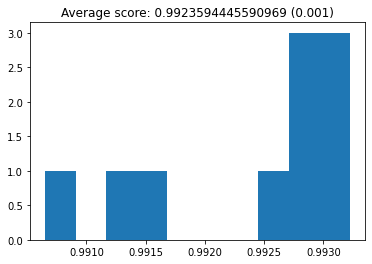

In [5]:
import sklearn.tree as tree
from numpy import std
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.figure(figsize=(10, 200))
    plt.imshow(masks, interpolation='none', cmap='gray_r')
    plt.ylabel('Fold')
    plt.xlabel('Row #')

all_inputs = X
all_labels = y
# plot_cv(StratifiedKFold(n_splits=10), all_inputs[:100], all_labels[:100])

decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, scoring='accuracy', cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)) + ' (%.3f)' % std(cv_scores))

# Repeated Cross-Validation

### Box Plot
The orange line indicates the median of the distribution and the green triangle represents the arithmetic mean. If these symbols (values) coincide, it suggests a reasonable symmetric distribution and that the mean may capture the central tendency well.

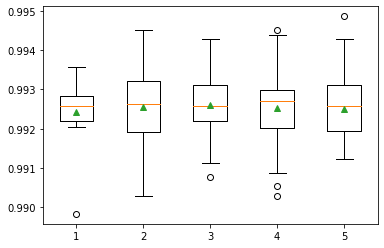

In [124]:
from sklearn.model_selection import RepeatedKFold

repeats = range(1,6)
results = list()

for r in repeats:
    cv = RepeatedKFold(n_splits=10, n_repeats=r, random_state=1)
    decision_tree_classifier = DecisionTreeClassifier()

    # cross_val_score returns a list of the scores, which we can visualize
    # to get a reasonable estimate of our classifier's performance
    cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, scoring='accuracy', cv=cv)
    
    results.append(cv_scores)

plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

# Stratified Cross-Validation

In [6]:
from sklearn.metrics import accuracy_score 

skf = StratifiedKFold(n_splits=5)
target = y
model = DecisionTreeClassifier()

def train_model(train, test, fold_no):
    X_train = train[train.columns.difference(['default_ind'])]
    y_train = train['default_ind']
    X_test = test[train.columns.difference(['default_ind'])]
    y_test = test['default_ind']
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print('Fold', str(fold_no), 'Accuracy:', accuracy_score(y_test, predictions))


fold_no = 1
for train_index, test_index in skf.split(dtc_df, target):
    train = dtc_df.iloc[train_index]
    test = dtc_df.iloc[test_index]
    #print('Fold', str(fold_no), 'Class Ratio:', sum(test['default_ind']) / len(test['default_ind']))
    train_model(train, test, fold_no) 
    fold_no += 1

Fold 1 Accuracy: 0.9936915887850467
Fold 2 Accuracy: 0.9928150008762194
Fold 3 Accuracy: 0.9922308546059934
Fold 4 Accuracy: 0.9918803668438577
Fold 5 Accuracy: 0.9919387814708803


# Logistic Regression

**COPIED:**

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

Accuracy of logistic regression (liblinear) classifier on test set: 0.99


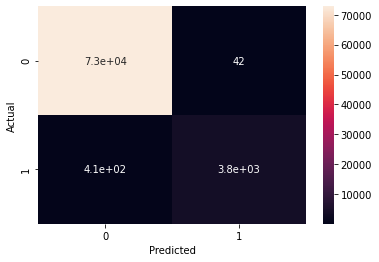

In [165]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=0)
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)


confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sb.heatmap(confusion_matrix, annot=True)
print('Accuracy of logistic regression (liblinear) classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression (lbfgs) classifier on test set: 0.95


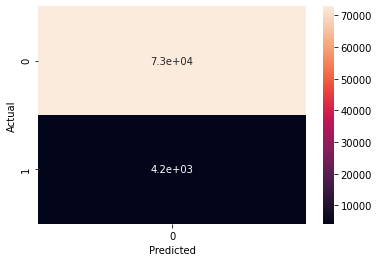

In [164]:
"""from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)
X_test = mm_scaler.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy_score = logreg.score(X_test, y_test)

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sb.heatmap(confusion_matrix, annot=True)
print('Accuracy of logistic regression (lbfgs) classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))"""

# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("data_clean.csv", index_col=0)
svc_df = df

columnsToEncode = list(svc_df.select_dtypes(include=['category','object']))
le = LabelEncoder()
for feature in columnsToEncode:
    try:
        svc_df[feature] = le.fit_transform(svc_df[feature])
    except:
        print('Error encoding '+feature)
        
X = svc_df[df.columns.difference(['default_ind'])].values # Features
y = svc_df['default_ind'].values

(training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(X, y, test_size=0.25, stratify=df[['default_ind']])

svc = SVC(kernel='linear', class_weight='balanced')
scaler = StandardScaler()
training_inputs = scaler.fit_transform(training_inputs)
start = time.time()
print("SVM fit...")
svc.fit(training_inputs, training_classes)
print("SVM fit in {} seconds".format(time.time()-start))    
print("SVM predicting...")
start = time.time()
pred = svc.predict(testing_inputs)
print("SVM completed in {} seconds".format(time.time()-start))

print(metrics.confusion_matrix(testing_classes, pred))
print(metrics.classification_report(testing_classes, pred))

wow
wtf
SVM fit...
